# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [24]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from deap import algorithms, base, benchmarks, tools, creator
import seaborn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Instance Creation

In [4]:


def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d


### Population Generation, Fitness, Mutation, and Xover

In [5]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(len(individual)):
                if knapsack == individual[j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    f3 = min(knapsacks_profit)

    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    return f1, f2, f3

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,


### Running EA

In [6]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

### Single Execution Script

In [186]:
def execute_EA(instance):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0, 1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", favorite_child_xover)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    res,logbook = run_ea(toolbox)

    fronts = tools.emo.sortLogNondominated(res, len(res))
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    
    st_front = []
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df = df.rename(columns={0: "f1", 1: "f2", 2: "f3"})
        ax1.scatter3D(df.f1, df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax2.scatter(df.f1, df.f2, label='Front'+str(i+1), color=plot_colors[i])
        ax3.scatter(df.f1, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax4.scatter(df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        st_front.append(df)
    ax1.legend();ax2.legend();ax3.legend();ax4.legend()
    ax1.set_xlabel('$f_1(\mathbf{x})$');ax1.set_ylabel('$f_2(\mathbf{x})$');ax1.set_zlabel('$f_3(\mathbf{x})$')
    ax2.set_xlabel('$f_1(\mathbf{x})$');ax2.set_ylabel('$f_2(\mathbf{x})$')
    ax3.set_xlabel('$f_1(\mathbf{x})$');ax3.set_ylabel('$f_3(\mathbf{x})$')
    ax4.set_xlabel('$f_2(\mathbf{x})$');ax4.set_ylabel('$f_3(\mathbf{x})$')
    
    stats = []
    for i in range(len(st_front)):
        df = pd.DataFrame({'mean_f1' : [np.mean(st_front[i].f1)],
                           'median_f1' : [np.median(st_front[i].f1)], 
                           'variance_f1': [np.var(st_front[i].f1)], 
                           'sample_size': [len(st_front[i].f1)], 
                           'min_f1': [min(st_front[i].f1)], 
                           'max_f1': [max(st_front[i].f1)],
                           'mean_f2' : [np.mean(st_front[i].f2)],
                           'median_f2' : [np.median(st_front[i].f2)], 
                           'variance_f2': [np.var(st_front[i].f2)], 
                           'sample_size': [len(st_front[i].f2)], 
                           'min_f2': [min(st_front[i].f2)], 
                           'max_f2': [max(st_front[i].f2)],
                           'mean_f3' : [np.mean(st_front[i].f3)],
                           'median_f3' : [np.median(st_front[i].f3)], 
                           'variance_f3': [np.var(st_front[i].f3)], 
                           'sample_size': [len(st_front[i].f3)], 
                           'min_f3': [min(st_front[i].f3)], 
                           'max_f3': [max(st_front[i].f3)]
                          })
        stats.append(df)
    return res,logbook, fronts, stats

### Multiple Instance Testing Function

In [ ]:
### TODO: Make this function

## Running and Testing
### Single Execution

/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	max    	avg    
0  	50    	16447.7	6342.14
1  	37    	16983  	6485.61
2  	41    	16983  	6584.85
3  	43    	17307.2	6697.67
4  	40    	17307.2	6607.08
5  	42    	17961.9	6585.78
6  	42    	17961.9	6481.91
7  	42    	17961.9	6218.91
8  	40    	17961.9	6336.79
9  	42    	17961.9	6013.66
10 	41    	17961.9	6296.73
11 	45    	18233.8	6194.69
12 	42    	18240.6	6430.68
13 	39    	18240.6	6398.54
14 	41    	18240.6	6283.41
15 	43    	18240.6	6049.95
16 	45    	18240.6	6239.17
17 	46    	18240.6	6333.29
18 	43    	18240.6	6382.34
19 	47    	18278.2	6401.91
20 	41    	18278.2	6529.95
[        mean_f1     median_f1   variance_f1  sample_size  min_f1  \
0  14218.949211  14357.750347  5.720364e+06           50  9125.0   

         max_f1  mean_f2  median_f2  variance_f2  min_f2  max_f2  mean_f3  \
0  18278.229868  1656.34     1681.5   43869.1444    1290    2138  3714.56   

   median_f3  variance_f3  min_f3  max_f3  
0     3624.0  910519.4464    2216    5756  ]
CPU times: user 1.52 s, 

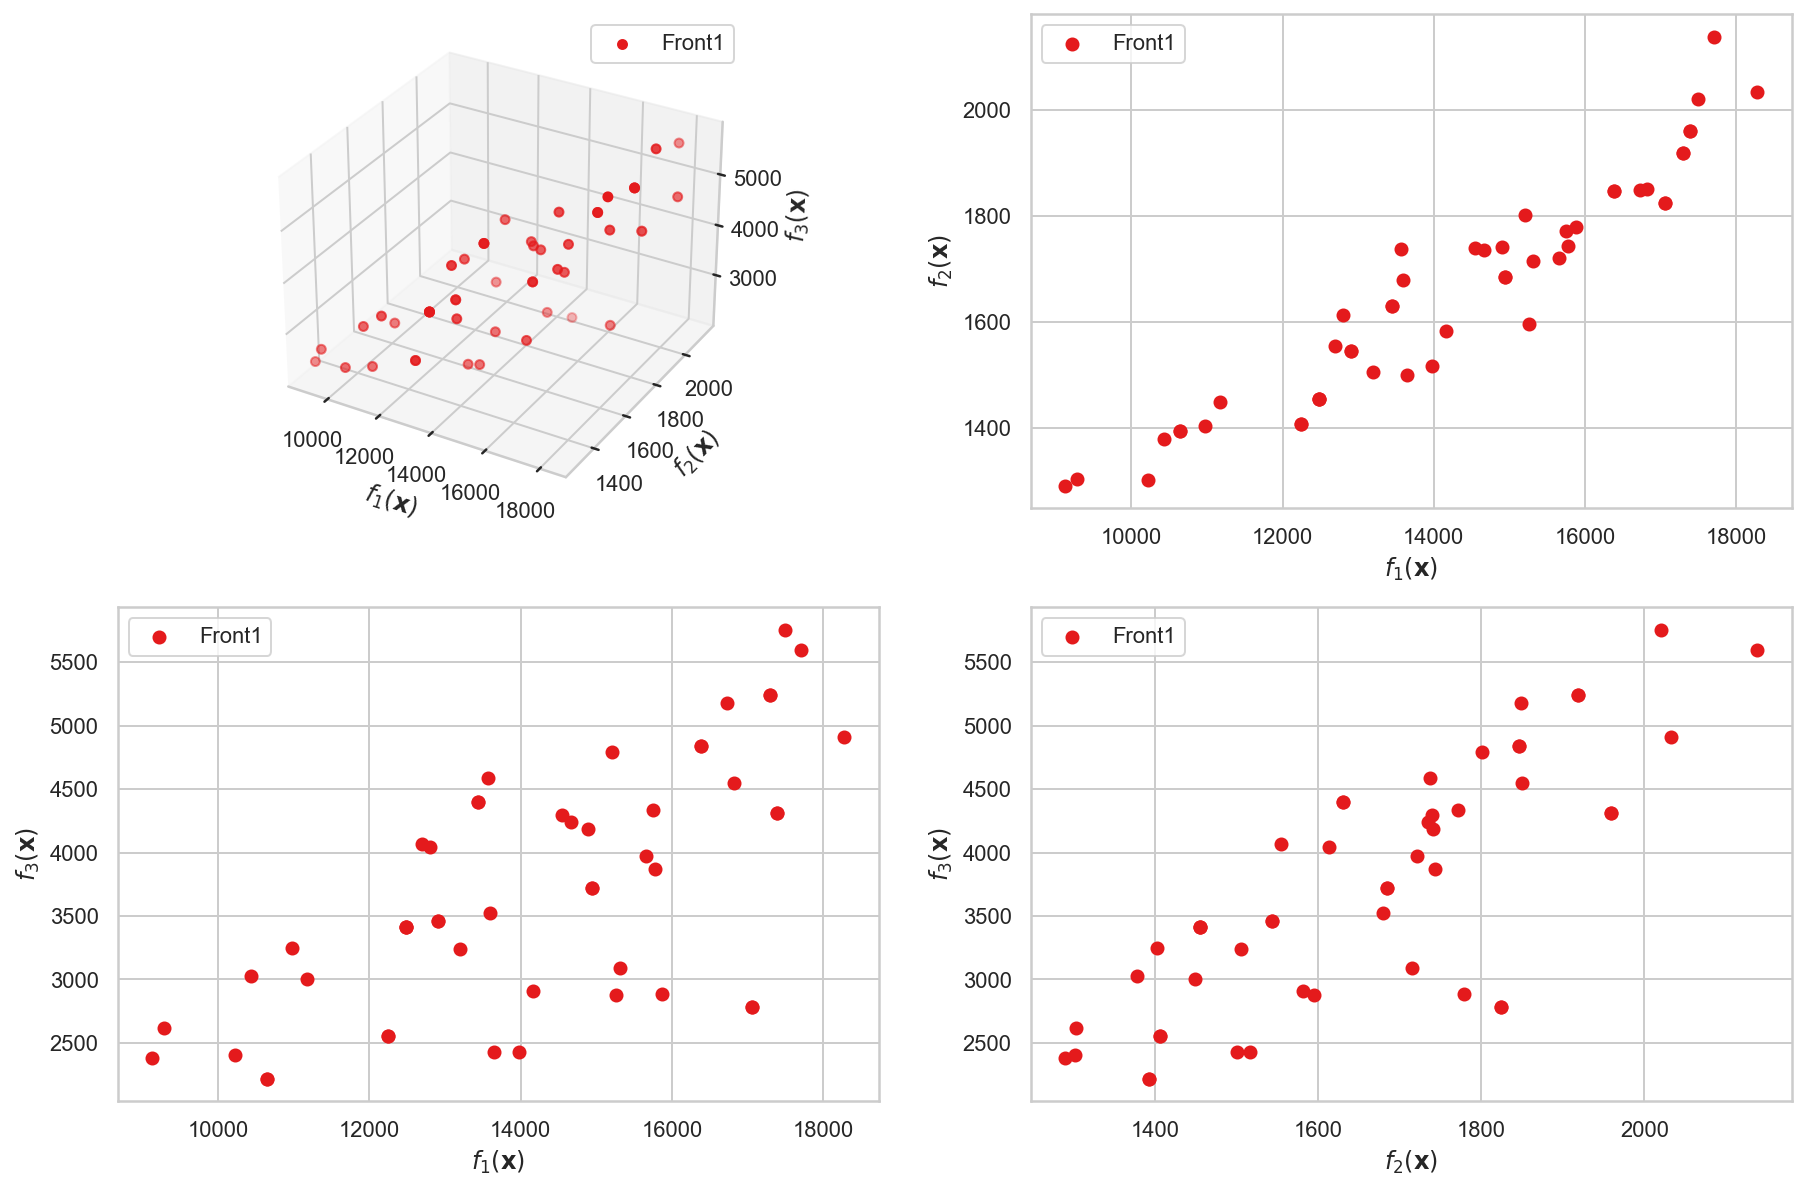

In [187]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate
instance = instance_create('jeu_100_25_1.txt', 3, 50, 20, .05, .8)
%time res, logbook, fronts, stats = execute_EA(instance)

### Generating Instances

In [31]:
### TODO: create function to generate all the instances we need for testing


117
